## Import statements and loading the data

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import collections

2025-05-16 23:46:43.069309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
f = h5py.File('bird_spectrograms.hdf5', 'r')
list(f.keys())

['amecro',
 'amerob',
 'bewwre',
 'bkcchi',
 'daejun',
 'houfin',
 'houspa',
 'norfli',
 'rewbla',
 'sonspa',
 'spotow',
 'whcspa']

In [3]:
for key in list(f.keys()):
    print(f[key].shape)

(128, 517, 66)
(128, 517, 172)
(128, 517, 144)
(128, 517, 45)
(128, 517, 125)
(128, 517, 84)
(128, 517, 630)
(128, 517, 37)
(128, 517, 187)
(128, 517, 263)
(128, 517, 137)
(128, 517, 91)


In [4]:
# set seeds to ensure reproducibility 
np.random.seed(5322)
tf.random.set_seed(5322)
random.seed(5322)

## Multiclass Classification (All species)

In [5]:
X_list = []
y_list = []

# loop through each species' data
for species in list(f.keys()):
    spectrograms = np.array(f[species]) # (128, 517, N)
    n_samples = spectrograms.shape[2]
    labels = [species] * n_samples

    X_list.append(spectrograms)
    y_list.extend(labels)

In [6]:
# stack and reshape
X = np.concatenate(X_list, axis = 2) # (128, 517, total_samples)
X = np.transpose(X, (2, 0, 1)) # (samples, 128, 517)
X = X[..., np.newaxis] # (samples, 128, 517, 1)

In [7]:
# labels to arrays
y = np.array(y_list)

In [8]:
# encode species to ints
le = LabelEncoder()
y_encoded = le.fit_transform(y) # amecro = 0, amerob = 1, ...
label_map = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = len(le.classes_)
num_classes

12

In [9]:
# normalize per spectrogram to [0, 1]
X_min = np.min(X, axis = (1, 2, 3), keepdims = True)
X_max = np.max(X, axis = (1, 2, 3), keepdims = True)
X = (X - X_min) / (X_max - X_min + 1e-8)

In [10]:
# stratified split to get aligned train/test splits for both X, onehot labels, and raw integer labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size = 0.2, random_state = 5322, stratify = y_encoded
)

In [12]:
# sanity check class distribution and weights
print("Training set class distribution:")
print(collections.Counter(y_train))

# number of classes
print(f"\nNumber of classes: {num_classes}")

Training set class distribution:
Counter({6: 504, 9: 210, 8: 149, 1: 137, 2: 115, 10: 110, 4: 100, 11: 73, 5: 67, 0: 53, 3: 36, 7: 30})

Number of classes: 12


## First Multiclass Model
- Started simple with 3 layers
- No L2 regularization yet
- Only dropout in dense layer
- Learning rate of 0.001
- Kept same padding to preserve the spatial resolution across layers
- Added a min delta in early stopping since simple models tend to oscillate with small changes leading endless runs

In [13]:
# first multiclass model
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), input_shape = (128, 517, 1), activation = 'relu',  padding = 'same'),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalAveragePooling2D(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.3),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_1")

model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, min_delta = 0.01)

history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping]
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 517, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 258, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 258, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 129, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 129, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 64, 128)

In [14]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

# get class labels in correct order
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_test, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 4s 279ms/step
              precision    recall  f1-score   support

      amecro     0.0000    0.0000    0.0000        13
      amerob     0.0000    0.0000    0.0000        35
      bewwre     0.0000    0.0000    0.0000        29
      bkcchi     0.0000    0.0000    0.0000         9
      daejun     0.0000    0.0000    0.0000        25
      houfin     0.0000    0.0000    0.0000        17
      houspa     0.3174    1.0000    0.4818       126
      norfli     0.0000    0.0000    0.0000         7
      rewbla     0.0000    0.0000    0.0000        38
      sonspa     0.0000    0.0000    0.0000        53
      spotow     0.0000    0.0000    0.0000        27
      whcspa     0.0000    0.0000    0.0000        18

    accuracy                         0.3174       397
   macro avg     0.0264    0.0833    0.0402       397
weighted avg     0.1007    0.3174    0.1529       397



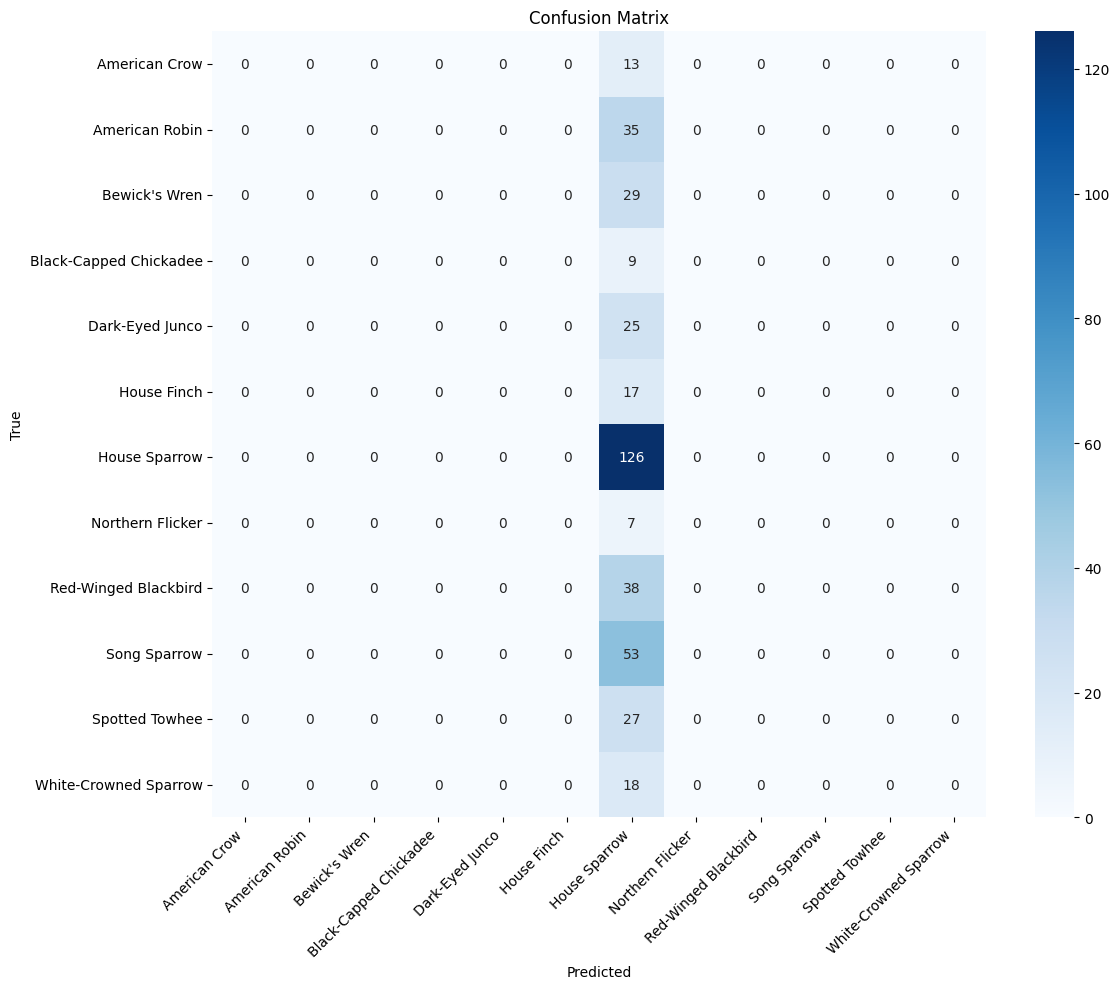

In [15]:
# confusion matrix
# species_names = list(f.keys())
common_name = ['American Crow', 'American Robin', 'Bewick\'s Wren', 'Black-Capped Chickadee', 'Dark-Eyed Junco', 'House Finch',
                'House Sparrow', 'Northern Flicker', 'Red-Winged Blackbird', 'Song Sparrow', 'Spotted Towhee', 'White-Crowned Sparrow']

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = common_name, yticklabels = common_name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 360, ha = 'right')
plt.tight_layout()
plt.show()

- This model does better than random guessing the accuracy, however, the accuracy here is misleading
- The macro precision 0.0264 and macro recall 0.0833, indicate the model is doing terribly and it is not learning effectively across all classes
- Class imbalance leads the model to predict House Sparrow, our majority class, every single time, which is why accuracy is high, but with only one class predicted

## Second Multiclass Classification
- Created class weights to try and handle some of the class imbalance
- Increased complexity by adding another layer since the previous model was underfitting
- Lowered learning rate to 0.0001 from 0.001 since 0.001 made little improvement and oscillated in loss and accuracy. take smaller and more precise steps this time
- Also added reduce learning rate on plateau to adjust learning rate even further if needed
- Lowered batch size from 64 to 32 since smaller batches can generalize better on smaller or imbalanced datasets
- Set the patience for early stopping to 7 to possibly allow for more learning in this version
- Added batch normalization to help with training and stability since we added another layer
- Increased dropout in dense layer to 0.5 to possibly reduce overfitting with the new layer
- Increased the filters in dense layer to 128 units since we added another layer with 256 filters. might be able to learn more abstract features this time

In [16]:
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

class_weights_dict = dict(enumerate(class_weights))

In [17]:
# second multiclass model
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), input_shape = (128, 517, 1), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 4
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalAveragePooling2D(),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.5),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_2")

model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose = 1)

history = model.fit(
    X_train,
    y_train,
    batch_size = 32,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping, reduce_lr],
    class_weight = class_weights_dict
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 517, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 517, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 258, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 258, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 258, 64)       256       
 chNormalization)                                                
                                                

In [18]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

# get class labels in correct order (by integer encoding)
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_test, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 9s 680ms/step
              precision    recall  f1-score   support

      amecro     0.0000    0.0000    0.0000        13
      amerob     0.0000    0.0000    0.0000        35
      bewwre     0.0730    1.0000    0.1362        29
      bkcchi     0.0000    0.0000    0.0000         9
      daejun     0.0000    0.0000    0.0000        25
      houfin     0.0000    0.0000    0.0000        17
      houspa     0.0000    0.0000    0.0000       126
      norfli     0.0000    0.0000    0.0000         7
      rewbla     0.0000    0.0000    0.0000        38
      sonspa     0.0000    0.0000    0.0000        53
      spotow     0.0000    0.0000    0.0000        27
      whcspa     0.0000    0.0000    0.0000        18

    accuracy                         0.0730       397
   macro avg     0.0061    0.0833    0.0113       397
weighted avg     0.0053    0.0730    0.0099       397



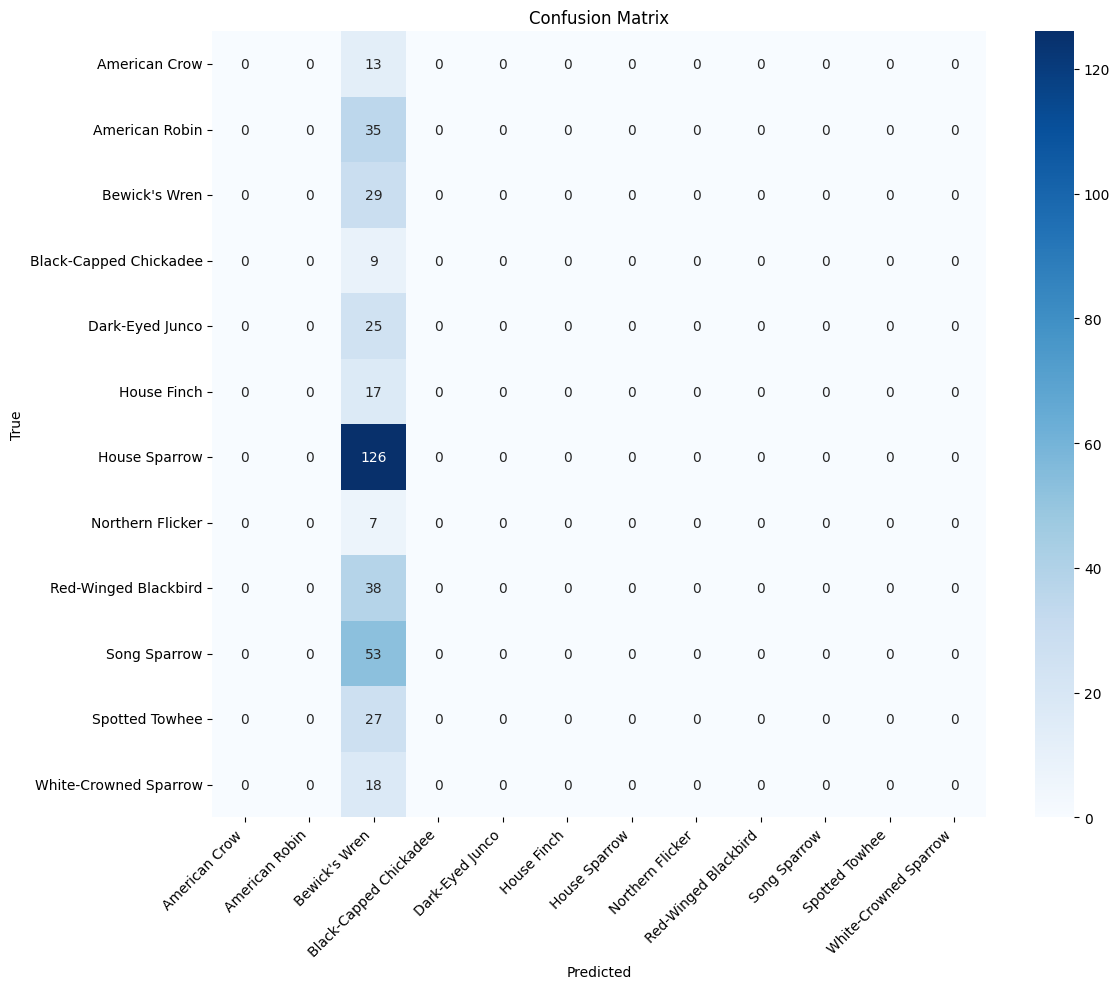

In [19]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = common_name, yticklabels = common_name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 360, ha = 'right')
plt.tight_layout()
plt.show()

- This model did not do well at all and is underfitting since it cannot get decent accuracy or loss
- I think the class weights actually had a negative impact on the model. Likely caused more instability given our model was not even learning effectively in the first iteration
- This model only guessed a minority class, Bewick's Wren, and no other class (not even majority classes), which indicates the model collapsed

## Third Multiclass Model
- Removed class weights
- Added another layer to start the network at 16 filters to give the model more learning capacity (to help with underfitting above)
- Increased the learning rate back to 0.001 since 0.0001 was unstable and not learning
- No significant dropout or L2 since the model is still underfitting significantly

In [20]:
# third multiclass model
model = Sequential([
    # layer group 1
    Conv2D(16, (3, 3), input_shape = (128, 517, 1), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 2
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 3
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 4
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # group 5
    Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    # global pooling
    GlobalAveragePooling2D(),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.5),
    Dense(units = num_classes, activation = 'softmax')
], name = "Multiclass_Model_3")

model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose = 1)

history = model.fit(
    X_train,
    y_train,
    batch_size = 32,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping, reduce_lr]
)

# result
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')

Model: "Multiclass_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 517, 16)      160       
                                                                 
 batch_normalization_4 (Bat  (None, 128, 517, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 258, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 258, 32)       4640      
                                                                 
 batch_normalization_5 (Bat  (None, 64, 258, 32)       128       
 chNormalization)                                                
                                                

In [21]:
# predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

# get class labels in correct order (by integer encoding)
target_names = [label_map[i] for i in sorted(label_map.keys())]

print(classification_report(y_test, y_pred, target_names = target_names, digits = 4, zero_division = 0))

13/13 [==============================] - 6s 429ms/step
              precision    recall  f1-score   support

      amecro     0.8000    0.3077    0.4444        13
      amerob     0.8696    0.5714    0.6897        35
      bewwre     0.4783    0.3793    0.4231        29
      bkcchi     0.6667    0.2222    0.3333         9
      daejun     0.6818    0.6000    0.6383        25
      houfin     0.8125    0.7647    0.7879        17
      houspa     0.8112    0.9206    0.8625       126
      norfli     0.0000    0.0000    0.0000         7
      rewbla     0.5789    0.5789    0.5789        38
      sonspa     0.5397    0.6415    0.5862        53
      spotow     0.3571    0.5556    0.4348        27
      whcspa     0.5000    0.5000    0.5000        18

    accuracy                         0.6574       397
   macro avg     0.5913    0.5035    0.5233       397
weighted avg     0.6625    0.6574    0.6474       397



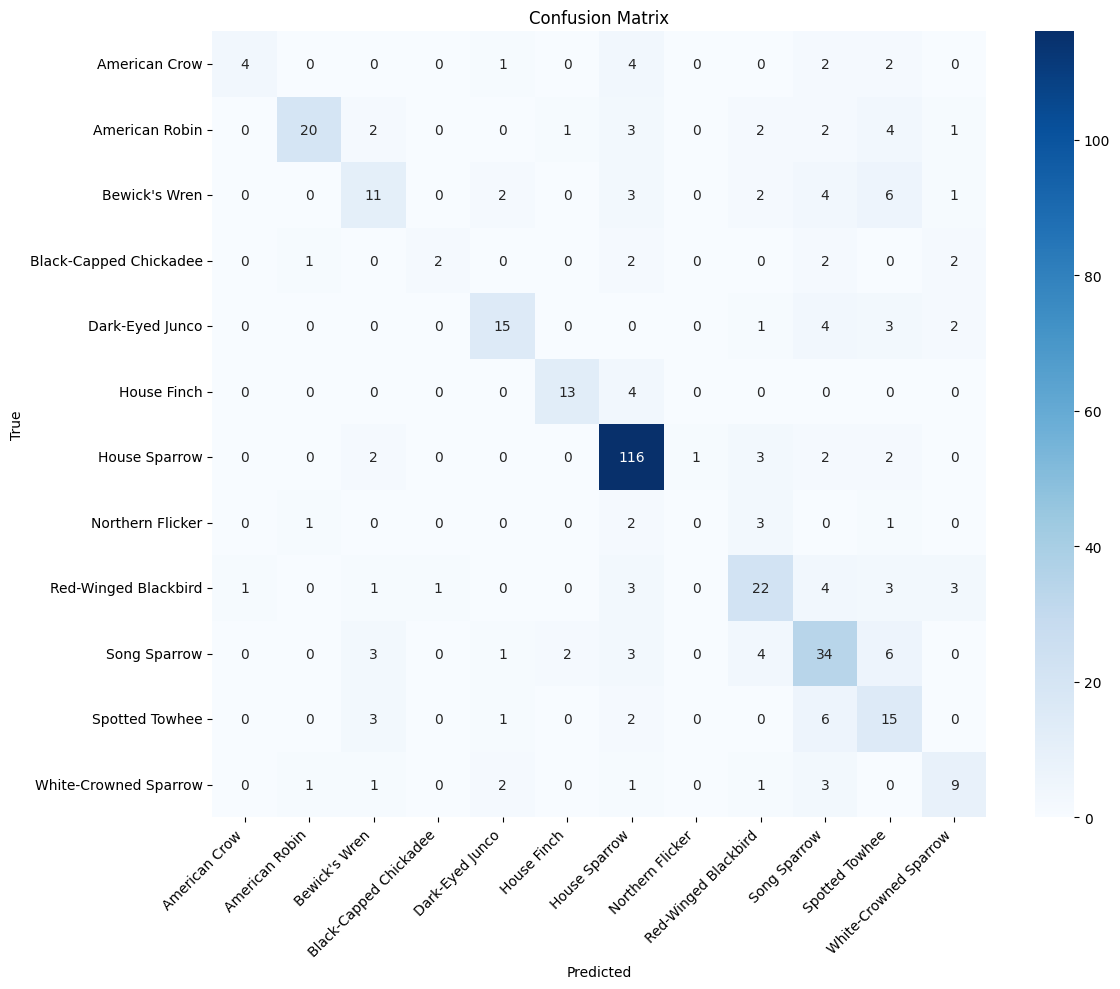

In [22]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = common_name, yticklabels = common_name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 360, ha = 'right')
plt.tight_layout()
plt.show()

- Struck gold with this tuning setup
- Model does overfit, however, it does significantly better than the previous 2 models
- The model overfits because of the higher training accuracy and lower validation accuracy (~30% gap towards the end)
- This model is definitely learning and fitting well
- Predicts all classes except northern flicker which is understandable given it had the least amount of samples
- Overall, 65% test accuracy with predictions across all classes, and good precision and recall for majority classes like house sparrow, and decent precision and recall for medium classes like song sparrow and house finch indicate decent model

## Prediction on the 3 sample audios

## Generate the spectrograms from the 3 test audio files

In [23]:
import soundfile as sf
import os
from scipy.signal import spectrogram
from tensorflow.keras.preprocessing import image

In [24]:
audio_folder = 'test/'
output_folder = 'test_spectrograms/'
os.makedirs(output_folder, exist_ok = True)

for filename in os.listdir(audio_folder):
    if filename.endswith('.mp3'):
        file_path = os.path.join(audio_folder, filename)
        print(f"Processing {filename}")

        # load audio file
        y, sr = sf.read(file_path)

        # convert stereo to mono if needed
        if len(y.shape) > 1:
            y = y.mean(axis = 1)

        # compute spectrogram
        f, t, Sxx = spectrogram(y, sr, nperseg = 1024, noverlap = 512)

        # convert to dB scale
        Sxx_dB = 10 * np.log10(Sxx + 1e-10)

        # plot and save just to see spectrogram
        plt.figure(figsize = (10, 4))
        plt.pcolormesh(t, f, Sxx_dB, shading = 'gouraud')
        plt.colorbar(format = '%+2.0f dB')
        plt.title(f'Spectrogram for {filename}')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.tight_layout()

        output_file = os.path.join(output_folder, filename.replace('.mp3', '.png'))
        plt.savefig(output_file)
        plt.close()

print("Done generating spectrograms.")

Processing test3.mp3
Processing test2.mp3
Processing test1.mp3
Done generating spectrograms.


## Make the predictions using the third model which was the best we could do

In [25]:
spectrogram_folder = 'test_spectrograms/'
spectrogram_files = [f for f in os.listdir(spectrogram_folder) if f.endswith('.png')]

for filename in spectrogram_files:
    file_path = os.path.join(spectrogram_folder, filename)
    
    # Load the image
    spectrogram = plt.imread(file_path).astype('float32')

    # Handle RGBA images (drop alpha channel)
    if spectrogram.shape[-1] == 4:
        print(f"Warning: {filename} has 4 channels (RGBA), dropping alpha.")
        spectrogram = spectrogram[:, :, :3]

    # Convert RGB to grayscale
    if spectrogram.ndim == 3 and spectrogram.shape[2] == 3:
        spectrogram = 0.2989 * spectrogram[:, :, 0] + \
                      0.5870 * spectrogram[:, :, 1] + \
                      0.1140 * spectrogram[:, :, 2]

    # Expand dims to make it (H, W, 1)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    # Now resize with proper shape
    spectrogram_resized = image.smart_resize(spectrogram, (128, 517))

    # Normalize
    spectrogram_resized = spectrogram_resized / 255.0

    # Add batch dimension for prediction: (1, H, W, C)
    spectrogram_resized = np.expand_dims(spectrogram_resized, axis=0)

    print(f"{filename} input shape: {spectrogram_resized.shape}")

    # Predict
    predictions = model.predict(spectrogram_resized)

    # Top 3 predictions
    top_3_idx = np.argsort(predictions[0])[::-1][:3]
    top_3_probs = predictions[0][top_3_idx]

    print(f"\nPredictions for {filename}:")
    for i, (idx, prob) in enumerate(zip(top_3_idx, top_3_probs)):
        print(f"Top {i+1} Prediction: Class {common_name[idx]}, Probability: {prob:.4f}")


test1.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 43ms/step

Predictions for test1.png:
Top 1 Prediction: Class Song Sparrow, Probability: 0.3235
Top 2 Prediction: Class House Sparrow, Probability: 0.1655
Top 3 Prediction: Class Red-Winged Blackbird, Probability: 0.1222
test3.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 45ms/step

Predictions for test3.png:
Top 1 Prediction: Class Song Sparrow, Probability: 0.3235
Top 2 Prediction: Class House Sparrow, Probability: 0.1655
Top 3 Prediction: Class Red-Winged Blackbird, Probability: 0.1223
test2.png input shape: (1, 128, 517, 1)
1/1 [==============================] - 0s 44ms/step

Predictions for test2.png:
Top 1 Prediction: Class Song Sparrow, Probability: 0.3234
Top 2 Prediction: Class House Sparrow, Probability: 0.1656
Top 3 Prediction: Class Red-Winged Blackbird, Probability: 0.1223


Not too surprising\
Our model only predicted/trained well (if trained at all) on 3 species, so the predictions were pretty much going to be the 3 species we had\
Since there was data imbalance, it is logical the model would predict the majority class most often which is what we see with house sparrow\
It does seem at least, that the model was able to notice that the audio spectrograms of the three files were different given the 3 very slightly different probabilities in the predictions, however, given out lacking model, they were pretty similar in their predictions\
Given the computation constraints of using a 2019 macbook and our imbalanced dataset plus the time constraints of even running each model, we did the best we could :)